In [1]:
# Code to process data for figures 3c,d,e, and S9b,c
from hsi_detect.utils import *
import matplotlib
from hsi_detect.grid_analysis import GridAnalysis
matplotlib.rcParams['pdf.fonttype'] = 42


In [25]:
# Initialize analysis with directory names
pa = GridAnalysis(savedir = 'data/outputs/grid_analysis', 
               use_saved = False, 
               ctrl_img_path = 'data/input/087_ELOP Eden Fleshler/results/REFLECTANCE_087.hdr',
               expt_img_paths = [
                 'data/input/087_ELOP Eden Fleshler/results/REFLECTANCE_087.hdr'
               ],  
               concentration_map = 'concentration_map.csv', 
                plastic_ratio=0.7
              )

Parameters_file: data/outputs/grid_analysis/saved_params.json


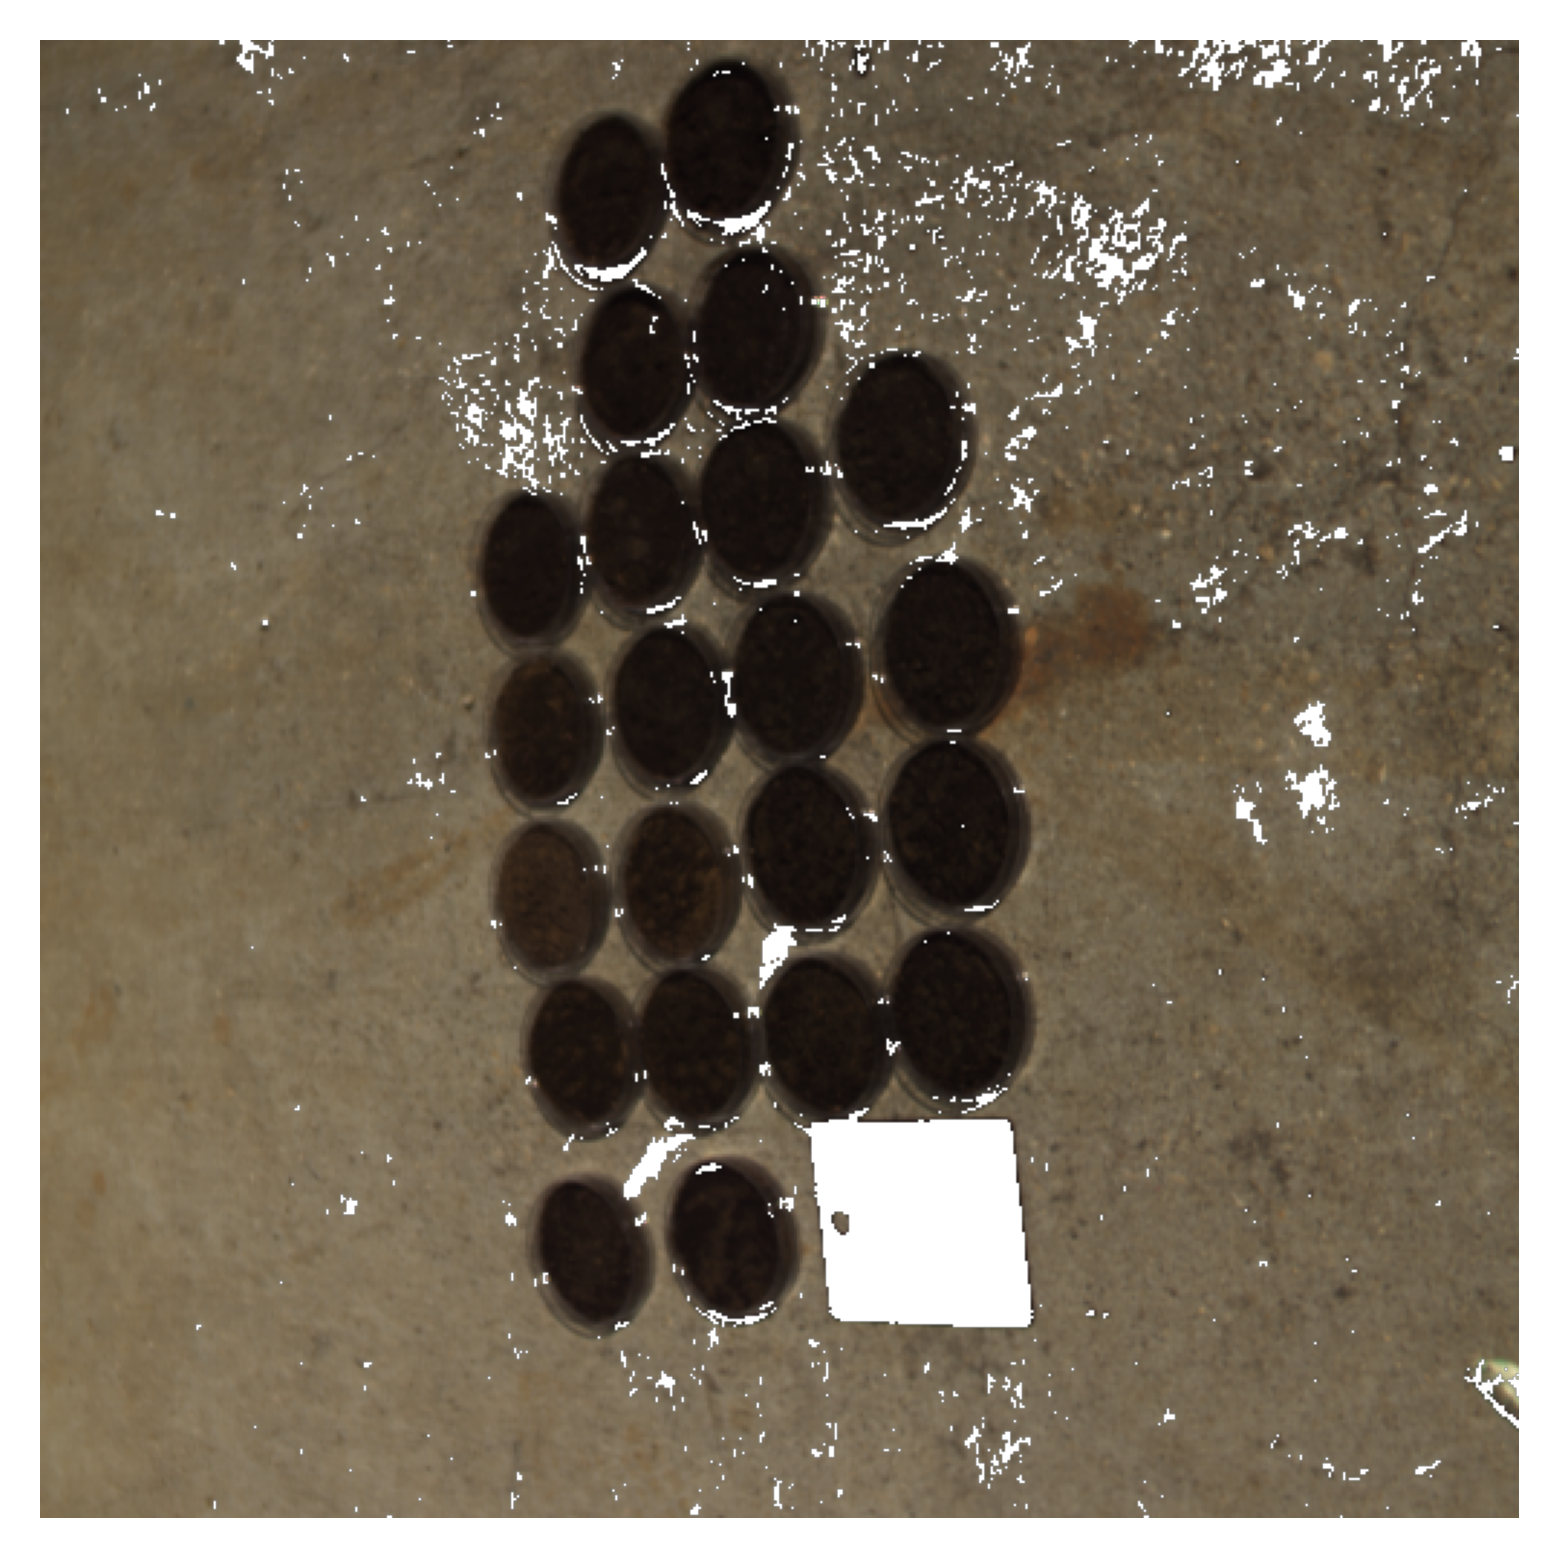

In [27]:
# Visualize the (masked) images of the experiments
for img in pa.expt_imgs:
    plt.figure(dpi=400)
    plt.imshow((img.rgb*img.plastic_mask).astype(int))
    plt.xticks([])
    plt.yticks([])
    plt.box(False)
    plt.show()

In [29]:
# To define the coordinates of the controls - simply click the center of the
# control samples. The spectrum will appear below.

# If saved parameters are not being used, rerunning this cell will erase
# the control coordinates variables. An arbitrary number of points can be 
# selected

if not pa.use_saved:
    pa.define_ctrl_coordinates_interactive()

ConnectionError: HTTPConnectionPool(host='18.30.133.177', port=8553): Max retries exceeded with url: /_alive_a7ba2aa7-94b6-4539-8ad1-da8f1bb7cf8d (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x168af2310>: Failed to establish a new connection: [Errno 60] Operation timed out'))

In [9]:
??pa.define_ctrl_coordinates_interactive

Signature: pa.define_ctrl_coordinates_interactive()
Docstring: <no docstring>
Source:   
    def define_ctrl_coordinates_interactive(self):
        self.bg_centers = np.array([]).reshape(0, 2) 
        cmap = plt.get_cmap('tab20')
        external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
        app = Dash(__name__, external_stylesheets=external_stylesheets)
        img_toshow = self.ctrl_img.rgb.astype(np.uint8)
        fig = px.imshow(img_toshow)
        app.layout = html.Div([ 
            html.Div([dcc.Graph(id='img',figure=fig)]),                      
            html.Div([dcc.Graph(id='spec-graph')])
                              ])
        def get_spectrum(selected_pixels):

            fig = px.scatter (x=[400], y=[0])
            for i, (pix_x, pix_y) in enumerate(selected_pixels):
                fig.add_trace(
                    go.Scatter(x=self.ctrl_img.centers, y=np.array(self.ctrl_img.image)[pix_y, pix_x, :])
                )
            fig.update

In [9]:
# To define the coordinates of the experimental grids - follow the instructions
# above the image and select the four corners of the grid + one additional point
# to calculate the sample radii in the appropriate order.

# If saved parameters are not being used, rerunning this cell will erase
# the coordinates variables.

if not pa.use_saved:
    pa.define_pellet_coordinates_interactive()

In [ ]:
if not pa.use_saved:
    pa.save_parameters()
pa.params

In [ ]:
# Showing where data is being measured from in the image. Everything else is 
# masked out
pa.get_grids()
pa.visualize_area_of_averaging(rectangles=False, background='rgb', color='white')


In [ ]:
# Defines the reference absorbance spectrum of the reporter
# based on the difference between the mean reflectance of the control
# and maximally induced samples

s = pa.get_specs()
pa.define_reference_spectrum(use_ctrl_img=True)

In [13]:
r_wl = 660
g_wl = 550
b_wl = 480

#Get narrow band absorbances
r_abs_grid = pa.get_narrow_band_abs(r_wl, subtract_min=False)
g_abs_grid = pa.get_narrow_band_abs(g_wl, subtract_min=False)
b_abs_grid = pa.get_narrow_band_abs(b_wl, subtract_min=False)
max_abs_grid = pa.get_narrow_band_abs(pa.max_abs, subtract_min=False)

In [ ]:
# classify HSI image
from hsi_detect.classifier import HierarchicalKMeansUnmixer
unmixing_classifier = HierarchicalKMeansUnmixer()
pa.score_w_unmixing(unmixing_classifier, remove_plastic=True)

In [ ]:
pa.visualize_area_of_averaging(rectangles=True, background='rgb')
pa.visualize_area_of_averaging(rectangles=True, background='hsi', cmap='inferno')

pa.visualize_area_of_averaging(rectangles=False, background='rgb', color='white')
pa.visualize_area_of_averaging(rectangles=False, background='hsi', cmap='inferno', color='white', vmin=0, vmax=1)

In [ ]:
pa.expt_imgs[2].conc_map

In [20]:
# ??pa._visualuze_area_of_averaging

In [ ]:
pa.visualize_area_of_averaging(rectangles=False, background='rgb', color='white', remove_background=True)
pa.visualize_area_of_averaging(rectangles=False, background='hsi', cmap='inferno', color='white', remove_background=True)

In [ ]:
def get_narrow_band_abs_baselined (img_ls, wavelength, baseline_val, threshold=None):
    """
    Returns the mean of the infered absorbance at a designated wavelength for each pellet as a matrix
    """
    print (baseline_val)
    fxn = lambda x : np.nanmean(x)
    abs_grid = []
    for i, img in enumerate(img_ls):
        narrow_band_img = 1 - img.image[:,:,get_closest_wl_ind(wavelength, img.centers)].copy() - baseline_val        
        if threshold is not None:
            narrow_band_img[narrow_band_img<threshold] = 0

        abs_scores = pa._apply_fxn_to_grid(fxn, img, narrow_band_img)
        img.narrow_band_abs[wavelength] = abs_scores
        abs_grid.append(abs_scores)
    return abs_grid



#absorbance at wavelength for control pellets
centers = pa.expt_imgs[0].centers
ctrl_r = 1 - pa.neg_spec[get_closest_wl_ind(r_wl, centers)]
ctrl_g = 1 - pa.neg_spec[get_closest_wl_ind(g_wl, centers)]
ctrl_b = 1 - pa.neg_spec[get_closest_wl_ind(b_wl, centers)]
ctrl_abs = 1 - pa.neg_spec[get_closest_wl_ind(pa.max_abs, centers)]

r_grids = get_narrow_band_abs_baselined(pa.expt_imgs, r_wl, ctrl_r, threshold=0)
g_grids = get_narrow_band_abs_baselined(pa.expt_imgs, g_wl, ctrl_g, threshold=0)
b_grids = get_narrow_band_abs_baselined(pa.expt_imgs, b_wl, ctrl_b, threshold=0)
abs_grids = get_narrow_band_abs_baselined(pa.expt_imgs, pa.max_abs, ctrl_abs, threshold=0)

color = 'black'
# NORMALIZE=[True,True]

#PLOTTING PARAMS
x_lims_max_multiples = 15
x_lims_min_multiples = .03
y_lims_min_multiples = 1
y_lims_max_multiples = 0.95
pts=5000

all_scores = []
all_abs = []
all_concs = []
all_reds = []
all_blues = []
all_scores = []
all_abs = []
all_concs = []
all_reds = []
all_blues = []
all_greens = []
for i in range(len(pa.expt_imgs)):
    all_scores.extend(flatten_array(pa.unmixing_scores[i]))
    all_concs.extend(flatten_array(pa.expt_imgs[i].conc_map.values))
    all_reds.extend(flatten_array(r_grids[i]) )
    all_greens.extend(flatten_array(g_grids[i]) )
    all_blues.extend(flatten_array(b_grids[i]) )
    all_abs.extend(flatten_array(abs_grids[i]) )
    
all_scores = np.array(all_scores)
all_abs = np.array(all_abs)
all_concs = np.array(all_concs)
all_reds = np.array(all_reds)
all_blues = np.array(all_blues)

concs_to_plot = np.array(all_concs)[~(np.isnan(all_concs)|np.isnan(all_scores))]
scores_to_plot = np.array(all_scores)[~(np.isnan(all_concs)|np.isnan(all_scores))] 
abs_to_plot = np.array(all_abs)[~(np.isnan(all_concs)|np.isnan(all_scores))] #- ctrl_abs
reds_to_plot = np.array(all_reds)[~(np.isnan(all_concs)|np.isnan(all_scores))] #- ctrl_r
blues_to_plot = np.array(all_blues)[~(np.isnan(all_concs)|np.isnan(all_scores))] #- ctrl_b
greens_to_plot = np.array(all_greens)[~(np.isnan(all_concs)|np.isnan(all_scores))] #- ctrl_g



#baseline ? 
# abs_to_plot[]

In [ ]:
savepath = '{}/{}-{}-conc-vs-detection_hill_plot_unmixing.pdf'.format(pa.savedir, pa.date_str, 'putida_blvda_response_triplicate')

ymin = np.mean(scores_to_plot[concs_to_plot==np.min(concs_to_plot)])
ymax = np.mean(scores_to_plot[concs_to_plot==np.max(concs_to_plot)])
fit_fxn = lambda x, K, n: hill_eqn(x, ymin, ymax, K, n)
print (f'ymin {ymin}, ymax {ymax}, DR: {ymax/ymin}')

print ('SAVING PLOT TO', savepath)
plot_fit_curve(
                concs_to_plot,
                scores_to_plot,
                fit_fxn, 
               [np.min(concs_to_plot[concs_to_plot!=0])*x_lims_min_multiples, np.max(concs_to_plot)*x_lims_max_multiples], 
            [-0.02,1.1],
            savepath, 
               ymax_bound=np.inf,
    ymin_bound = -np.inf,
        marker_color='black', line_color='black', 
        figsize=(1.1,1.1), markersize=3, edgecolor='black',
                pts = pts, ylabel='Classification score', 
    x_offset=1e-6,
    fit_lower_bounds=[0.01,0.01], fit_upper_bounds=[np.inf,np.inf]
)



In [ ]:
for s in pa.expt_imgs[0].endmembers:
    plt.plot(s/np.max(s))

In [ ]:
# Visualize the background clustering used to define the "backgrounds" for signal decomposition
# Note that samples that have the reporter in them with a high likelihood are removed from
# the background calculation
for s in pa.expt_imgs:
    plt.figure(dpi=400)
    plt.imshow(np.reshape(s.clust_map, s.image.shape[:2]), cmap='tab20')
    plt.show()

In [ ]:
savepath = '{}/{}-{}-conc-vs-max_abs_only_hill_plot_unmixing.pdf'.format(pa.savedir, pa.date_str, 'putida_blvda_response_triplicate')

print ('SAVING PLOT TO', savepath)
plot_fit_curve(
                concs_to_plot,
                abs_to_plot,
                hill_eqn, 
               [np.min(concs_to_plot[concs_to_plot!=0])*x_lims_min_multiples, np.max(concs_to_plot)*x_lims_max_multiples], 
            [-0.02,0.6],
            savepath, 
               ymax_bound=np.inf,
    ymin_bound = 0,
        marker_color='black', line_color='black', 
        figsize=(1.1,1.1), markersize=3, edgecolor='black',
                pts = pts, ylabel='Absorbance', 
    x_offset=1e-6
)


In [ ]:
for ex in pa.expt_imgs:
    print (np.max(ex.conc_map.values))

In [ ]:
#PLOTTING PARAMS
x_lims_max_multiples = 15
x_lims_min_multiples = .03
y_lims_min_multiples = 1
y_lims_max_multiples = 0.95
pts=5000
f = lambda x : x


savepath = '{}/{}-{}-conc-vs-detection_hill_plot_rgb.pdf'.format(pa.savedir, pa.date_str, 'pputida_response_RGB_all_points')
print ('SAVING PLOT TO', savepath)
plot_fit_curves(#concs_to_plot[:outliers], 
               #means[:outliers], 
                [concs_to_plot,concs_to_plot,concs_to_plot, concs_to_plot],
                [
                    reds_to_plot, blues_to_plot, greens_to_plot, 
                    abs_to_plot],
#                 [(x-np.min(x))/(np.max(x) - np.min(x)) for x in [reds_to_plot, blues_to_plot, greens_to_plot, abs_to_plot]],
#             [(x-np.min(x))/(np.max(x) - np.min(x)) for x in [ abs_to_plot]],
                hill_eqn, 
               [np.min(concs_to_plot[concs_to_plot!=0])*x_lims_min_multiples, np.max(concs_to_plot)*x_lims_max_multiples], 
            [-0.01,0.5],
            savepath, 
               ymax_bounds=[1,1,1,1], 
        marker_colors=['red', 'blue', 'green', 'purple'],
        figsize=(1.1,1.1), markersize=3, 
                pts = pts, ylabel='Absorbance', fit_linewidth=0.5, match_line_colors=True
         #x_offset=1e-6
)

In [ ]:
def cnr (signal, concs):
    signal = np.array(signal)
    concs = np.array(concs)
    means_by_conc = [np.mean(signal[concs==c]) for c in np.unique(concs)]
    stds = [np.std(signal[concs==c]) for c in np.unique(concs)]
    return (np.max(means_by_conc) - np.min(means_by_conc)) / np.mean(stds)

def dr (signal, concs):
    signal = np.array(signal)
    concs = np.array(concs)
    means_by_conc = np.array([np.mean(signal[concs==c]) for c in np.unique(concs)])
    return means_by_conc[np.argmax(np.unique(concs))]  / means_by_conc[np.argmin(np.unique(concs))]

def snr (signal, concs):
    signal = np.array(signal)
    concs = np.array(concs)
    means_by_conc = [np.mean(signal[concs==c]) for c in np.unique(concs)]
    stds = [np.std(signal[concs==c]) for c in np.unique(concs)]
    return np.max(means_by_conc)  / np.mean(stds)

def drnr (signal, concs):
    signal = np.array(signal)
    concs = np.array(concs)
    means_by_conc = [np.mean(signal[concs==c]) for c in np.unique(concs)]
    stds = [np.std(signal[concs==c]) for c in np.unique(concs)]
    return dr(signal, concs)  / np.mean(stds)


print ('score SNR:', snr(scores_to_plot, concs_to_plot), 'score DR:', 
       dr(scores_to_plot, concs_to_plot), 'score CNR:', cnr(scores_to_plot, concs_to_plot), 
       'score DRNR:', drnr(scores_to_plot, concs_to_plot), )
print ('abs SNR:', snr(abs_to_plot, concs_to_plot),
       'abs DR:', dr(abs_to_plot, concs_to_plot), 
       'abs CNR:', cnr(abs_to_plot, concs_to_plot), 'abs DRNR:', drnr(abs_to_plot, concs_to_plot), )

print ('r SNR:', snr(reds_to_plot, concs_to_plot), 'r DR:', dr(reds_to_plot, concs_to_plot), 
       'r CNR:', cnr(reds_to_plot, concs_to_plot), 'red DRNR:', drnr(reds_to_plot, concs_to_plot),)
print ('g SNR:', snr(greens_to_plot, concs_to_plot), 'g DR:', dr(greens_to_plot, concs_to_plot),
       'g CNR:', cnr(greens_to_plot, concs_to_plot),'g DRNR:', drnr(greens_to_plot, concs_to_plot) )
print ('blues SNR:', snr(blues_to_plot, concs_to_plot), ' DR:', dr(blues_to_plot, concs_to_plot), 
       ' CNR:', cnr(blues_to_plot, concs_to_plot), ' DRNR:', drnr(blues_to_plot, concs_to_plot),)


In [ ]:
norm_fxn = lambda x : x / np.nanmax(x)

concs_to_show = [np.min(concs_to_plot), np.max(concs_to_plot)]
all_specs = np.vstack([np.stack([x for s in pa.expt_specs[i] for x in s]) for i in range(0,len(pa.expt_specs))])
centers =  pa.expt_imgs[0].centers

rwl = centers[get_closest_wl_ind(660, centers)]
gwl = centers[get_closest_wl_ind(540, centers)]
bwl = centers[get_closest_wl_ind(480, centers)]
abswl = centers[np.argmax(pa.reference_spectrum)]

spec_dict = {}
for c in np.unique(all_concs):
    if not np.isnan(c):
        spec_dict[c] = np.nanmean(all_specs[all_concs==c], axis=0)
        
        
plt.figure(figsize=(1.1,1.1))
cmap=plt.get_cmap('Blues')
for c, spec in spec_dict.items():
    if c == np.min(concs_to_plot):
        plt.plot(centers, norm_fxn(spec), color='black', label=c, zorder=3)
    elif c in concs_to_show: #<= np.unique(concs_to_plot)[-1]:
        plt.plot(centers, norm_fxn(spec), 
                 color=cmap(0.1+concs_to_show.index(c)/len(concs_to_show)), 
                 label=c)
        
        
plt.axvline(rwl, color='red', linestyle='--')
plt.axvline(bwl, color='blue', linestyle='--')
plt.axvline(gwl, color='green', linestyle='--')
plt.axvline(abswl, color='black', linestyle='--')

plt.xticks([400,600,800,1000])
plt.ylim(0.2,1.15)
plt.xlim(400,1000)
plt.yticks([0.5, 1])
plt.minorticks_on()
plt.legend(bbox_to_anchor=[-.5, -.5], loc='right')
plt.savefig(f'{pa.savedir}/{pa.date_str}_reflectance_spectra.pdf')
plt.show()

In [ ]:
norm_fxn = lambda x : x / np.nanmax(x)

concs_to_show = [0,0.01,1,5,1000]
all_specs = np.vstack([np.stack([x for s in pa.expt_specs[i] for x in s]) for i in range(0,len(pa.expt_specs))])
centers =  pa.expt_imgs[0].centers

rwl = centers[get_closest_wl_ind(660, centers)]
gwl = centers[get_closest_wl_ind(550, centers)]
bwl = centers[get_closest_wl_ind(480, centers)]
abswl = centers[np.argmax(pa.reference_spectrum)]

spec_dict = {}
for c in np.unique(all_concs):
    if not np.isnan(c):
        spec_dict[c] = np.nanmean(all_specs[all_concs==c], axis=0)
        
        
plt.figure(figsize=(1.1,1.1))
cmap=plt.get_cmap('Blues')
for c, spec in spec_dict.items():
    if c == np.min(concs_to_plot):
        plt.plot(centers, norm_fxn(spec), color='black', label=c, zorder=3)
    elif c in concs_to_show: #<= np.unique(concs_to_plot)[-1]:
        plt.plot(centers, norm_fxn(spec), 
                 color=cmap(0.1+concs_to_show.index(c)/len(concs_to_show)), 
                 label=c)
        
        
plt.axvline(rwl, color='red', linestyle='--')
plt.axvline(bwl, color='blue', linestyle='--')
plt.axvline(gwl, color='green', linestyle='--')
plt.axvline(abswl, color='black', linestyle='--')

plt.xticks([400,600,800,1000])
plt.ylim(0.2,1.15)
plt.xlim(400,1000)
plt.yticks([0.5, 1])
plt.minorticks_on()
plt.legend(bbox_to_anchor=[-.5, -.5], loc='right')
plt.savefig(f'{pa.savedir}/{pa.date_str}_selected_reflectance_spectra.pdf')
plt.show()

In [ ]:
img_idx = 2

masked_rgb = pa.expt_imgs[img_idx].rgb*pa.expt_imgs[img_idx].plastic_mask/255
#pick row or column here
pellet_centers = pa.expt_imgs[img_idx].coord_grid[2,:]

radius = int(pa.expt_imgs[img_idx].radius)


fig, ax = plt.subplots(len(pellet_centers))

for i, c in enumerate(pellet_centers):    
    x,y = c
    y = int(y)
    x = int(x)
    ax[i].imshow(masked_rgb[y-radius:y+radius, x-radius:x+radius,:])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    [s.set_visible(False) for s in ax[i].spines.values()]

fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.savefig(f'{pa.savedir}/{pa.date_str}_example_rgb_image_enlarged.pdf', transparent=True)
plt.show()

In [ ]:
masked_hsi = pa.expt_imgs[img_idx].scores*pa.expt_imgs[img_idx].plastic_mask[:,:,0]
fig, ax = plt.subplots(len(pellet_centers))
for i, c in enumerate(pellet_centers):    
    x,y = c
    y = int(y)
    x = int(x)
    ax[i].imshow(masked_hsi[y-radius:y+radius, x-radius:x+radius], cmap='inferno', vmin=0, vmax=1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    [s.set_visible(False) for s in ax[i].spines.values()]

fig.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.savefig(f'{pa.savedir}/{pa.date_str}_example_hsi_image_enlarged.pdf', transparent=True)
plt.show()